# Imports

In [1]:
import pandas as pd
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn import random_projection
from sklearn.random_projection import SparseRandomProjection
from sklearn.random_projection import GaussianRandomProjection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Loading the Dataset

In [70]:
pen_dataset = pd.read_csv('data/pendigits.csv', sep= ',')
X_pen = pen_dataset.values[:,:-2]
y_pen = pen_dataset.values[:,-1]

adult_dataset = pd.read_csv('data/adult.csv', sep= ',')
X_adult = adult_dataset.values[:,:-2]
y_adult = adult_dataset.values[:,-1]

# Normalizing the dataset
scaler = StandardScaler()

# Fitting on the training data
scaler.fit(X_adult, y_adult)

# Applying transformation to the training and test data
X_adult = scaler.transform(X_adult)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Functions

In [18]:
def silhouette_analysis(cluster_method, range_n_clusters, X, title, random_state):

    for n_clusters in range_n_clusters:

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        plt.xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        if cluster_method == "KMeans":
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X)
        elif cluster_method == "GMM":
            clusterer = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(X)
            cluster_labels = clusterer.predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.title(title + " - Silhouette plot with n_clusters = %d" % n_clusters)
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.show()
        
def silhouette_plot(cluster_method, range_n_clusters, X, title, random_state):
    
    silhouette_scores = []

    for n_clusters in range_n_clusters:

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        plt.xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        if cluster_method == "KMeans":
            clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
            cluster_labels = clusterer.fit_predict(X)
        elif cluster_method == "GMM":
            clusterer = GaussianMixture(n_components=n_clusters, covariance_type='full',random_state=random_state).fit(X)
            cluster_labels = clusterer.predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    max_idx = silhouette_scores.index(max(silhouette_scores))
    plt.clf()
    plt.plot(range_n_clusters, silhouette_scores, 'bx-')
    plt.plot(range_n_clusters[max_idx], silhouette_scores[max_idx], 'rx-')
    plt.title(title + " - Silhouette scores")
    plt.ylabel("Silhouette Score")
    plt.xlabel("Number of clusters")

    plt.show()
    
def plot_learning_curves(clf, all_X, y, title, X_titles, train_sizes=np.linspace(.1, 1.0, 5), cv=None, ylim=None, show=False):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_scores = []
    test_scores = []
    for X in all_X:
        train_sizes, train_score, test_score = learning_curve(clf, X, y, cv=cv, train_sizes=train_sizes)
        train_scores.append(train_score)
        test_scores.append(test_score)
        
    plt.grid()
    for i in range(len(X_titles)):
        test_score_mean = np.mean(test_scores[i], axis=1)
        plt.plot(train_sizes, test_score_mean, 'o-', label="CV Score: " + str(X_titles[i]))

    plt.legend(loc="best")
    #plt.savefig('plots/NN/learningcurves.png')
    if show: plt.show()
    plt.close()
    return

from scipy.linalg import pinv
import scipy.sparse as sps

def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)

# Experiment 1: Clustering

## kMeans Algorithm
### Adult Dataset
#### 1. Elbow Method to determine k

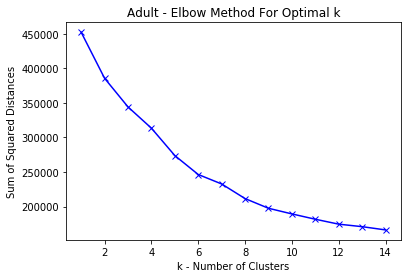

In [431]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_adult)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Adult - Elbow Method For Optimal k')
plt.show()

#### 2. Silhouette Method to determine k

For n_clusters = 2 The average silhouette_score is : 0.18058526328742858


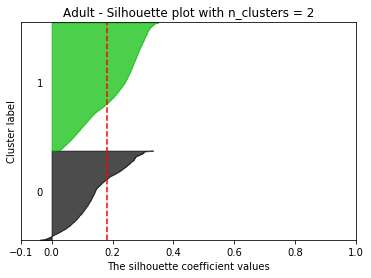

For n_clusters = 3 The average silhouette_score is : 0.20169304432939514


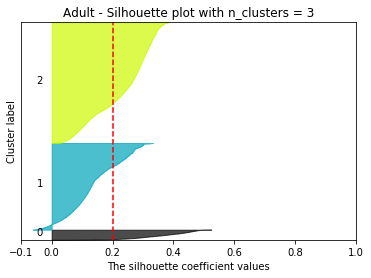

For n_clusters = 4 The average silhouette_score is : 0.19571599038937562


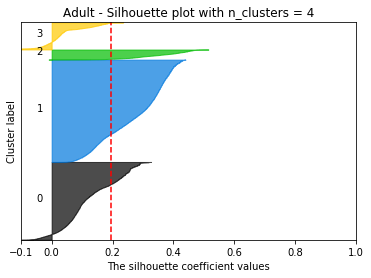

For n_clusters = 5 The average silhouette_score is : 0.15898055197033187


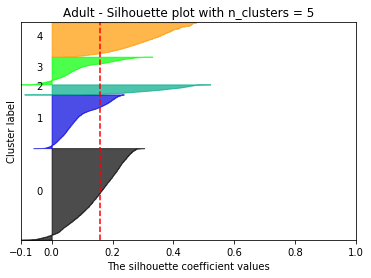

For n_clusters = 6 The average silhouette_score is : 0.21613323461814252


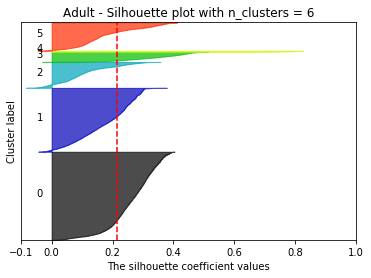

For n_clusters = 7 The average silhouette_score is : 0.19438632988486182


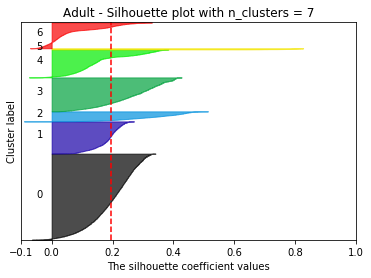

For n_clusters = 8 The average silhouette_score is : 0.18896140110062473


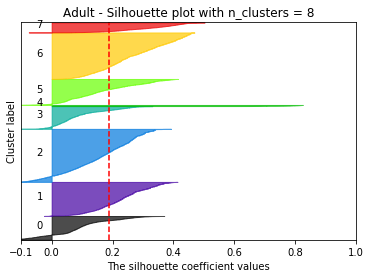

For n_clusters = 9 The average silhouette_score is : 0.19785983662946546


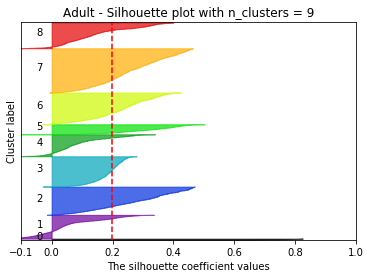

For n_clusters = 10 The average silhouette_score is : 0.2062249331974867


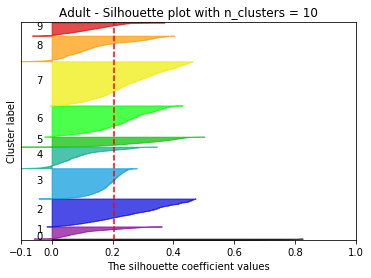

For n_clusters = 11 The average silhouette_score is : 0.2072946394091732


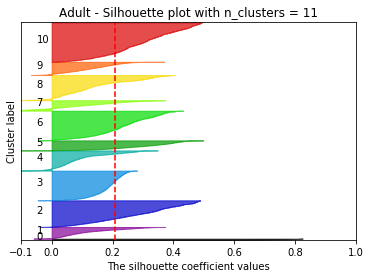

For n_clusters = 12 The average silhouette_score is : 0.19275574076896004


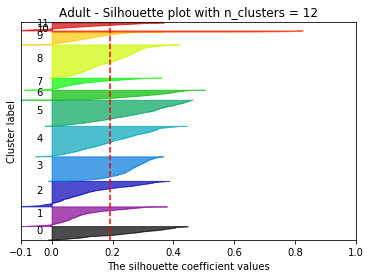

For n_clusters = 13 The average silhouette_score is : 0.19977091655176582


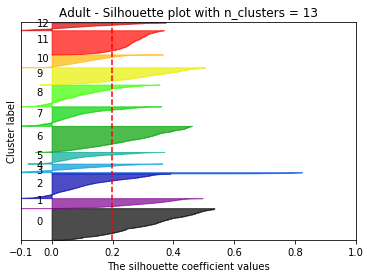

For n_clusters = 14 The average silhouette_score is : 0.20617367387441615


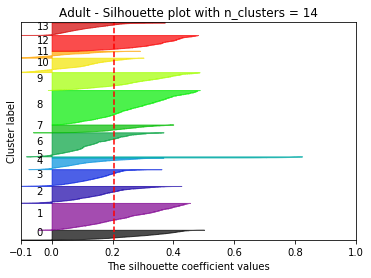

In [422]:
range_n_clusters = range(2,15)
silhouette_analysis("KMeans", range_n_clusters, X_adult, "Adult", 10)

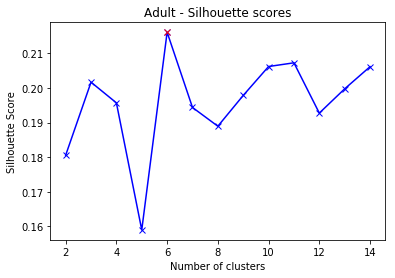

In [425]:
range_n_clusters = range(2,15)
silhouette_plot("KMeans", range_n_clusters, X_adult, "Adult", 10)

### Pen Digits Dataset
#### 1. Elbow Method to determine k

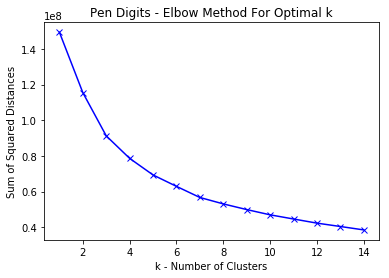

In [100]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_pen)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Pen Digits - Elbow Method For Optimal k')
plt.show()

#### 2. Silhouette Method to determine k

For n_clusters = 2 The average silhouette_score is : 0.23331726763046742


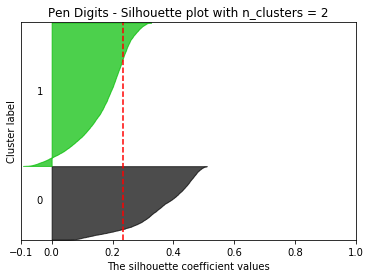

For n_clusters = 3 The average silhouette_score is : 0.269235890967976


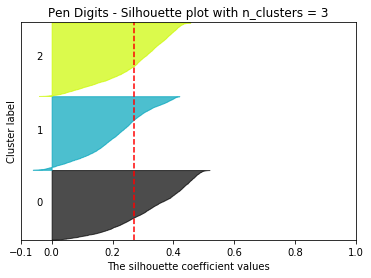

For n_clusters = 4 The average silhouette_score is : 0.2719981435655689


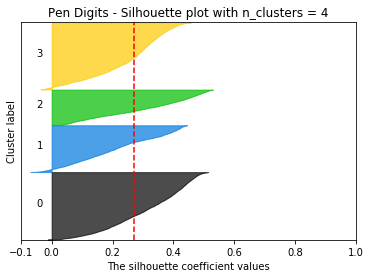

For n_clusters = 5 The average silhouette_score is : 0.29076559985655065


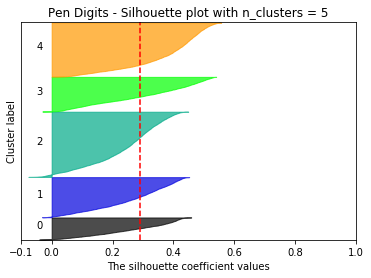

For n_clusters = 6 The average silhouette_score is : 0.28962867079019056


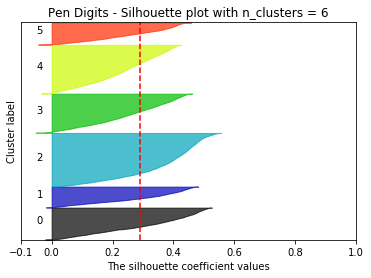

For n_clusters = 7 The average silhouette_score is : 0.3028396237533377


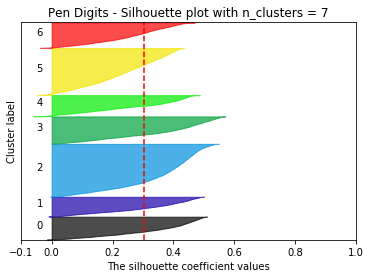

For n_clusters = 8 The average silhouette_score is : 0.30187053273914305


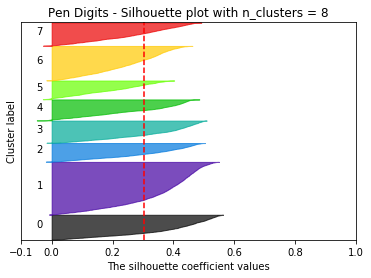

For n_clusters = 9 The average silhouette_score is : 0.30579318159380925


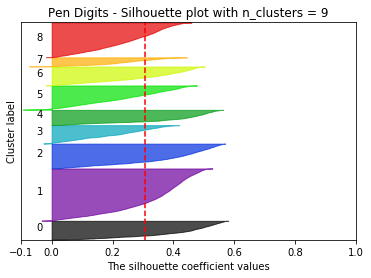

For n_clusters = 10 The average silhouette_score is : 0.31544200319903093


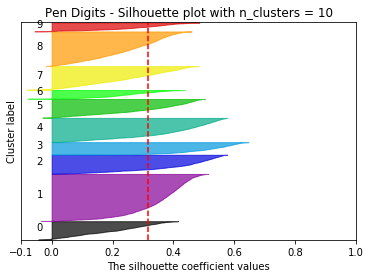

For n_clusters = 11 The average silhouette_score is : 0.28907998457850115


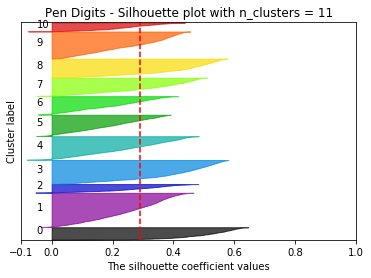

For n_clusters = 12 The average silhouette_score is : 0.281241042398341


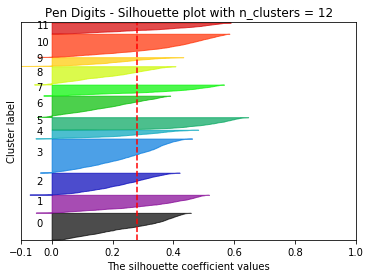

For n_clusters = 13 The average silhouette_score is : 0.28552013011915967


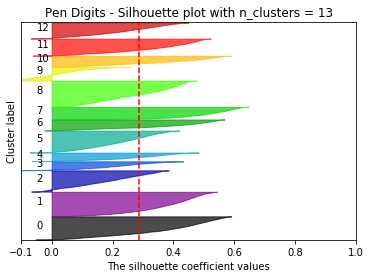

For n_clusters = 14 The average silhouette_score is : 0.2841760350247769


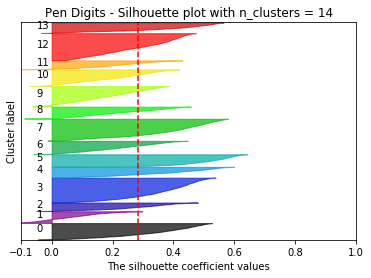

In [214]:
range_n_clusters = range(2,15)
silhouette_analysis("KMeans", range_n_clusters, X_pen, "Pen Digits", 10)

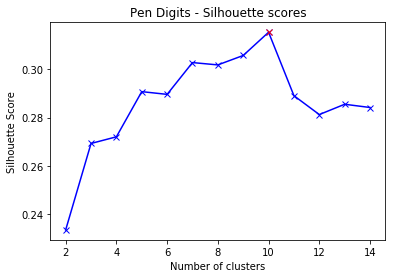

In [424]:
range_n_clusters = range(2,15)
silhouette_plot("KMeans", range_n_clusters, X_pen, "Pen Digits", 10)

## Expectation Maximization Algorithm

### Adult Dataset

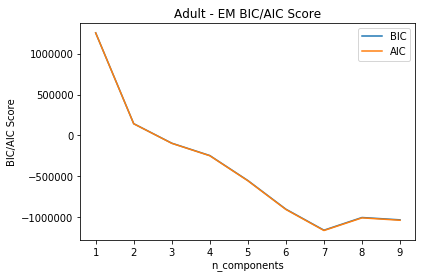

In [535]:
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=3).fit(X_adult)
          for n in n_components]

plt.plot(n_components, [m.bic(X_adult) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_adult) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('BIC/AIC Score')
plt.title('Adult - EM BIC/AIC Score')
plt.show()

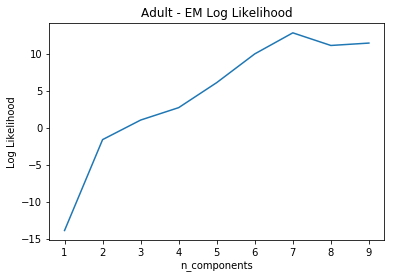

In [533]:
log_prob = np.zeros(9)

n = np.arange(1,10)
models = []
#loop through each number of Gaussians and compute the Log Prob, and save the model
for i,j in enumerate(n):
    #create mixture model with j components
    gmm = GaussianMixture(n_components=j, random_state=3)
    #fit it to the data
    gmm.fit(X_adult)
    #compute the Log Prob for this model
    log_prob[i] = gmm.score(X_adult)
    #add the best-fit model with j components to the list of models
    models.append(gmm)

plt.plot(n,log_prob)
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')
plt.title('Adult - EM Log Likelihood')
plt.show()

### Pen Digits Dataset

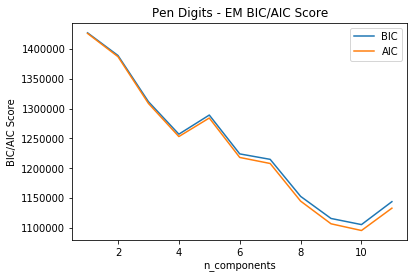

In [296]:
n_components = np.arange(1, 11+1)
models = [GMM(n, covariance_type='full', random_state=5).fit(X_pen)
          for n in n_components]

plt.plot(n_components, [m.bic(X_pen) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_pen) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('BIC/AIC Score')
plt.title('Pen Digits - EM BIC/AIC Score')
plt.show()

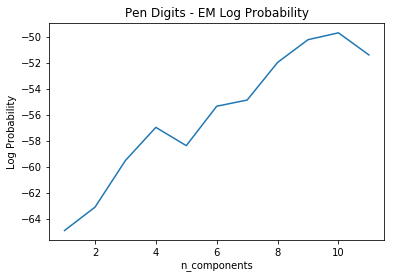

In [299]:
log_prob = np.zeros(11)

n = np.arange(1,12)
models = []
#loop through each number of Gaussians and compute the Log Prob, and save the model
for i,j in enumerate(n):
    #create mixture model with j components
    gmm = GaussianMixture(n_components=j, random_state=5)
    #fit it to the data
    gmm.fit(X_pen)
    #compute the Log Prob for this model
    log_prob[i] = gmm.score(X_pen)
    #add the best-fit model with j components to the list of models
    models.append(gmm)

plt.plot(n,log_prob)
plt.xlabel('n_components')
plt.ylabel('Log Probability')
plt.title('Pen Digits - EM Log Probability')
plt.show()

## Visualizing the clusters

### Adult Dataset
#### Ground Truth Class Labels grouping

In [466]:
training_x2D_adult = TSNE(verbose=False, random_state=10).fit_transform(X_adult)

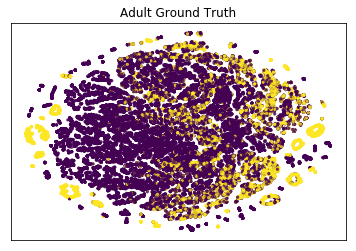

In [310]:
ds_2d = pd.DataFrame(np.hstack((training_x2D_adult, np.atleast_2d(y_adult).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Adult Ground Truth")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

#### Clustering Output
#### 1. K Means Clustering

In [462]:
km = KMeans(n_clusters=6, init='k-means++')
km = km.fit(X_adult)
y_pred_adult = km.labels_

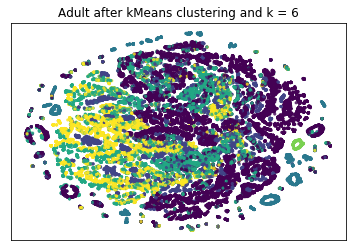

In [468]:
ds_2d = pd.DataFrame(np.hstack((training_x2D_adult, np.atleast_2d(y_pred_adult).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Adult after kMeans clustering and k = 6")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

#### 2. Expectation Maximization

In [336]:
gmm = GaussianMixture(n_components=7, covariance_type='full', random_state = 5)
gmm = gmm.fit(X_adult)
y_pred_adult = gmm.predict(X_adult)

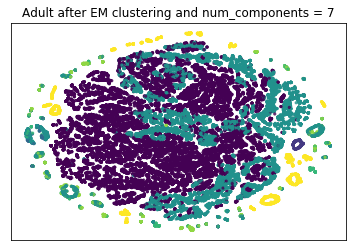

In [317]:
ds_2d = pd.DataFrame(np.hstack((training_x2D_adult, np.atleast_2d(y_pred_adult).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Adult after EM clustering and num_components = 7")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

### Pen Digits Dataset
#### Ground Truth Class Labels grouping

In [185]:
training_x2D_pen = TSNE(verbose=False, random_state=10).fit_transform(X_pen)

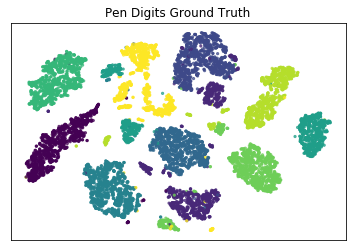

In [309]:
ds_2d = pd.DataFrame(np.hstack((training_x2D_pen, np.atleast_2d(y_pen).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Pen Digits Ground Truth")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

#### Clustering Output
#### 1. K Means Clustering

In [8]:
km = KMeans(n_clusters=10, init='k-means++')
km = km.fit(X_pen)
y_pred_pen = km.labels_

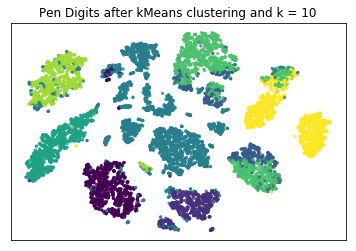

In [312]:
ds_2d = pd.DataFrame(np.hstack((training_x2D_pen, np.atleast_2d(y_pred_pen).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Pen Digits after kMeans clustering and k = 10")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

#### 2. Expectation Maximization

In [331]:
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state = 5)
gmm = gmm.fit(X_pen)
y_pred_pen = gmm.predict(X_pen)

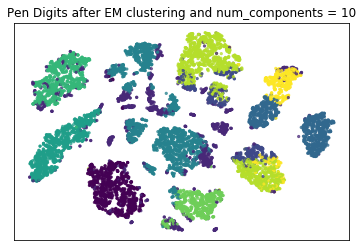

In [319]:
ds_2d = pd.DataFrame(np.hstack((training_x2D_pen, np.atleast_2d(y_pred_pen).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Pen Digits after EM clustering and num_components = 10")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

# Experiment 2 & 3: Dimensionality Reduction and Clustering
## PCA

### Pen Digits Dataset

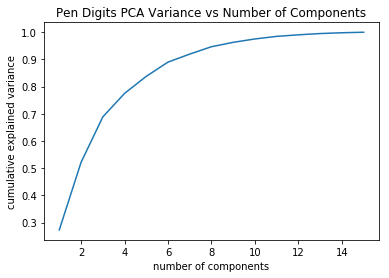

In [30]:
pca = PCA().fit(X_pen)
plt.plot(range(1,X_pen.shape[1]+1),np.cumsum(pca.explained_variance_ratio_))
plt.title("Pen Digits PCA Variance vs Number of Components")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

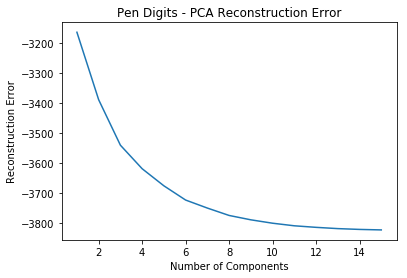

In [31]:
recon_error = []
    
for i in range(1, X_pen.shape[1]+1):
    pca = PCA(n_components=i)
    pca_projected_pen = pca.fit_transform(X_pen)
    error = (X_pen - pca.inverse_transform(pca_projected_pen) ** 2).mean()
    recon_error.append(error)

plt.plot(range(1,X_pen.shape[1]+1), recon_error)

plt.title("Pen Digits - PCA Reconstruction Error")
plt.ylabel("Reconstruction Error")
plt.xlabel("Number of Components")
plt.show()

(10991, 15)
(10991, 2)


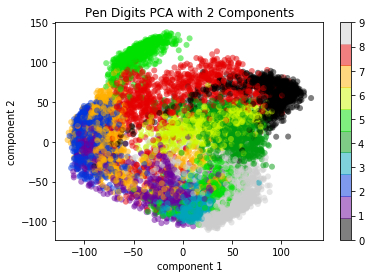

In [460]:
pca = PCA(n_components=2) # project from 15 to 2 dimensions
pca_projected_pen = pca.fit_transform(X_pen)
print(X_pen.shape)
print(pca_projected_pen.shape)

plt.scatter(pca_projected_pen[:, 0], pca_projected_pen[:, 1],
            c=y_pen, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.title("Pen Digits PCA with 2 Components")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

In [32]:
pca = PCA(n_components=5) # project from 15 to 5 dimensions
pca_projected_pen = pca.fit_transform(X_pen)
print(X_pen.shape)
print(pca_projected_pen.shape)

(10991, 15)
(10991, 5)


### Clustering after PCA on Pen Digits Dataset

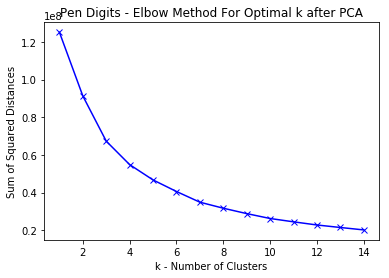

In [415]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pca_projected_pen)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Pen Digits - Elbow Method For Optimal k after PCA')
plt.show()

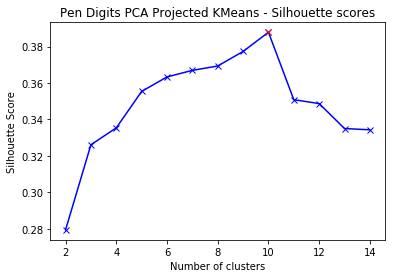

In [426]:
range_n_clusters = range(2,15)
silhouette_plot("KMeans", range_n_clusters, pca_projected_pen, "Pen Digits PCA Projected KMeans", 10)

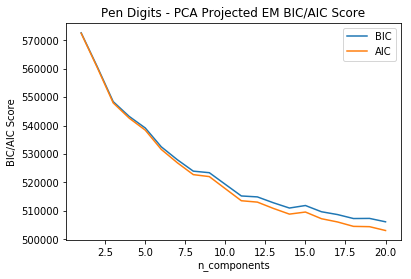

In [446]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full').fit(pca_projected_pen)
          for n in n_components]

plt.plot(n_components, [m.bic(pca_projected_pen) for m in models], label='BIC')
plt.plot(n_components, [m.aic(pca_projected_pen) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('BIC/AIC Score')
plt.title('Pen Digits - PCA Projected EM BIC/AIC Score')
plt.show()

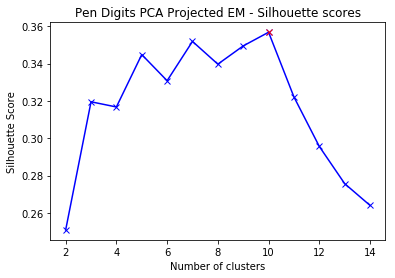

In [455]:
range_n_clusters = range(2,15)
silhouette_plot("GMM", range_n_clusters, pca_projected_pen, "Pen Digits PCA Projected EM", 5)

In [462]:
# #############################################################################
# Visualize the results on PCA-reduced data

pca = PCA(n_components=2) # project from 15 to 2 dimensions
reduced_data = pca.fit_transform(X_pen)
n_digits = 10
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

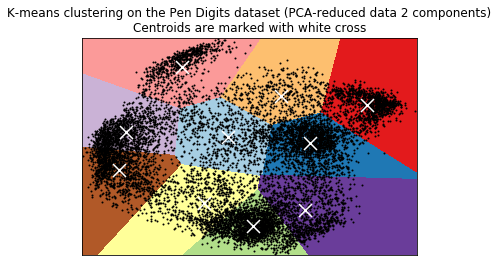

In [463]:
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the Pen Digits dataset (PCA-reduced data 2 components)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [313]:
training_x2D_pen_PCA = TSNE(verbose=False, random_state=10).fit_transform(pca_projected_pen)

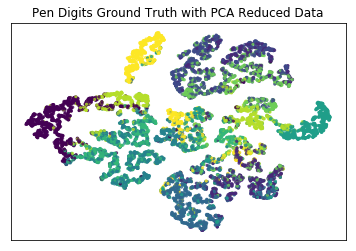

In [624]:
ds_2d = pd.DataFrame(np.hstack((training_x2D_pen_PCA, np.atleast_2d(y_pen).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Pen Digits Ground Truth with PCA Reduced Data")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

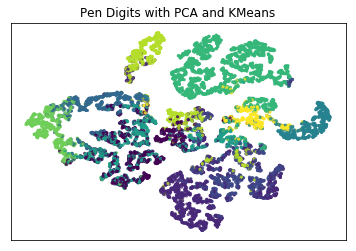

In [326]:
pca = PCA(n_components=8) # project from 15 to 2 dimensions
reduced_data = pca.fit_transform(X_pen)
n_digits = 10
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

ds_2d = pd.DataFrame(np.hstack((training_x2D_pen_PCA, np.atleast_2d(kmeans.labels_).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Pen Digits with PCA and KMeans")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

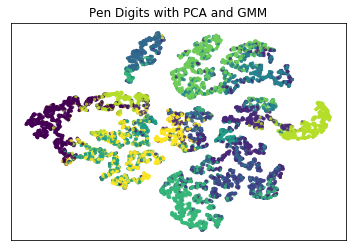

In [323]:
n_digits = 10
gmm = GaussianMixture(n_components=n_digits)
gmm = gmm.fit(reduced_data)

ds_2d = pd.DataFrame(np.hstack((training_x2D_pen_PCA, np.atleast_2d(gmm.predict(reduced_data)).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Pen Digits with PCA and GMM")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

### Adult Dataset

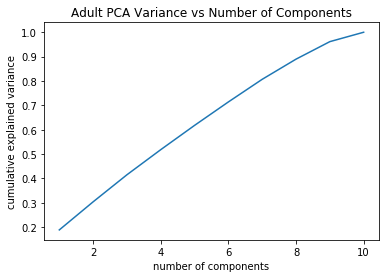

In [590]:
pca = PCA().fit(X_adult)
plt.plot(range(1,X_adult.shape[1]+1),np.cumsum(pca.explained_variance_ratio_))
plt.title("Adult PCA Variance vs Number of Components")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

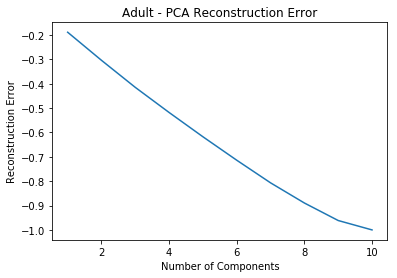

In [33]:
recon_error = []
    
for i in range(1, X_adult.shape[1]+1):
    pca = PCA(n_components=i)
    pca_projected_adult = pca.fit_transform(X_adult)
    error = (X_adult - pca.inverse_transform(pca_projected_adult) ** 2).mean()
    recon_error.append(error)

plt.plot(range(1,X_adult.shape[1]+1), recon_error)

plt.title("Adult - PCA Reconstruction Error")
plt.ylabel("Reconstruction Error")
plt.xlabel("Number of Components")
plt.show()

In [34]:
pca = PCA(n_components=6) # project from 90 to 6 dimensions
pca_projected_adult = pca.fit_transform(X_adult)
print(X_adult.shape)
print(pca_projected_adult.shape)

(45221, 10)
(45221, 6)


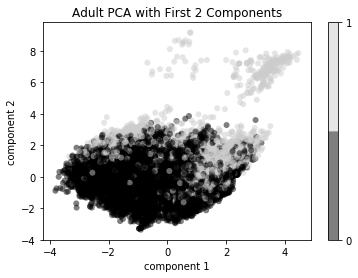

In [553]:
plt.scatter(pca_projected_adult[:, 0], pca_projected_adult[:, 1],
            c=y_adult, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 2))
plt.title("Adult PCA with First 2 Components")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar(ticks=[0, 1]);

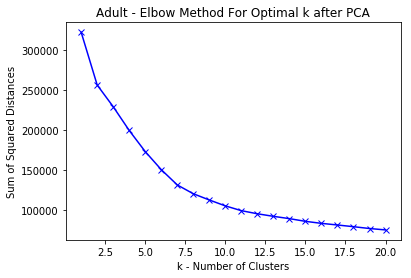

In [483]:
Sum_of_squared_distances = []
K = range(1,21)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pca_projected_adult)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Adult - Elbow Method For Optimal k after PCA')
plt.show()

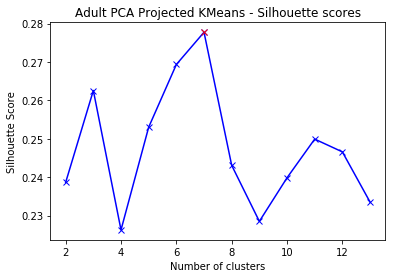

In [546]:
range_n_clusters = range(2,14)
silhouette_plot("KMeans", range_n_clusters, pca_projected_adult, "Adult PCA Projected KMeans", 10)

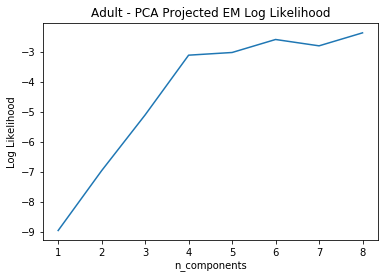

In [547]:
log_prob = np.zeros(8)

n = np.arange(1,9)
models = []
#loop through each number of Gaussians and compute the Log Prob, and save the model
for i,j in enumerate(n):
    #create mixture model with j components
    gmm = GaussianMixture(n_components=j, random_state=5)
    #fit it to the data
    gmm.fit(pca_projected_adult)
    #compute the Log Prob for this model
    log_prob[i] = gmm.score(pca_projected_adult)
    #add the best-fit model with j components to the list of models
    models.append(gmm)

plt.plot(n,log_prob)
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')
plt.title('Adult - PCA Projected EM Log Likelihood')
plt.show()

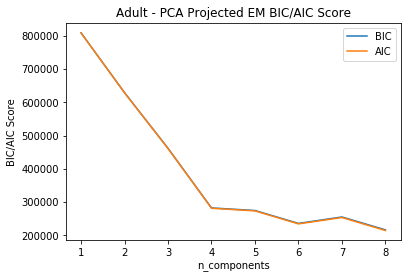

In [543]:
n_components = np.arange(1, 9)
models = [GaussianMixture(n, covariance_type='full', random_state=5).fit(pca_projected_adult)
          for n in n_components]

plt.plot(n_components, [m.bic(pca_projected_adult) for m in models], label='BIC')
plt.plot(n_components, [m.aic(pca_projected_adult) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('BIC/AIC Score')
plt.title('Adult - PCA Projected EM BIC/AIC Score')
plt.show()

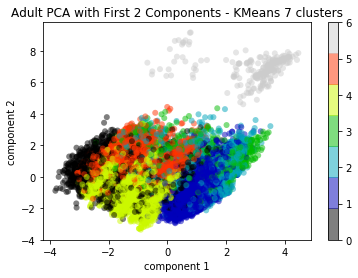

In [559]:
km = KMeans(n_clusters=7)
km = km.fit(pca_projected_adult)
plt.scatter(pca_projected_adult[:, 0], pca_projected_adult[:, 1],
            c=km.labels_, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 7))
plt.title("Adult PCA with First 2 Components - KMeans 7 clusters")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar(ticks=[0, 1, 2, 3, 4, 5, 6]);

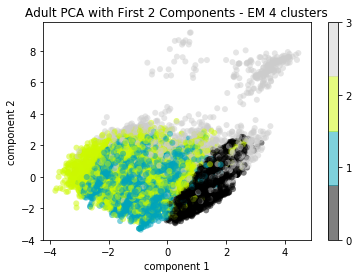

In [567]:
gmm = GaussianMixture(n_components=4)
gmm = gmm.fit(pca_projected_adult)
plt.scatter(pca_projected_adult[:, 0], pca_projected_adult[:, 1],
            c=gmm.predict(pca_projected_adult), edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 4))
plt.title("Adult PCA with First 2 Components - EM 4 clusters")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar(ticks=[0, 1, 2, 3]);

## ICA
### Pen Digits Dataset

In [45]:
ica = FastICA(random_state=10, max_iter=20000)
kurt_pen = {}
for dim in range(2,16):
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X_pen)
    #print(tmp.shape)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt_pen[dim] = tmp.abs().mean()

kurt_pen = pd.Series(kurt_pen)

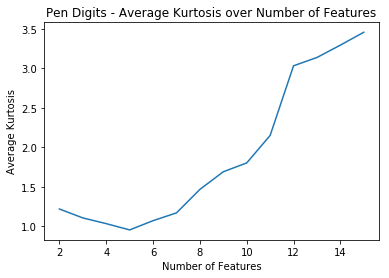

In [43]:
plt.plot(kurt_pen)
plt.title("Pen Digits - Average Kurtosis over Number of Features")
plt.ylabel('Average Kurtosis')
plt.xlabel('Number of Features');

In [39]:
ica = FastICA(random_state=10, max_iter=20000)
kurt_adult = {}
for dim in range(2,10):
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X_adult)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt_adult[dim] = tmp.abs().mean()

kurt_adult = pd.Series(kurt_adult)

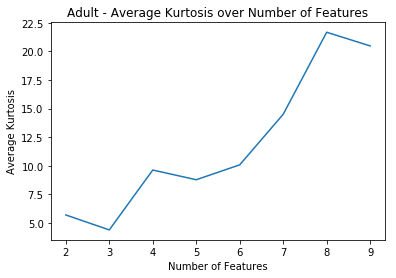

In [44]:
plt.plot(kurt_adult)
plt.title("Adult - Average Kurtosis over Number of Features")
plt.ylabel('Average Kurtosis')
plt.xlabel('Number of Features');

In [424]:
ica = FastICA(random_state=10, max_iter=20000)
ica.set_params(n_components=12)
ica_projected_pen = ica.fit_transform(X_pen)

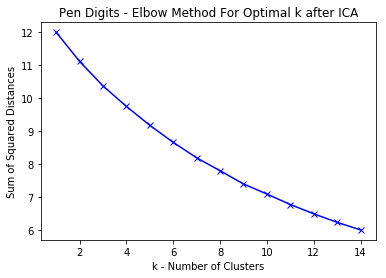

In [614]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(ica_projected_pen)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Pen Digits - Elbow Method For Optimal k after ICA')
plt.show()

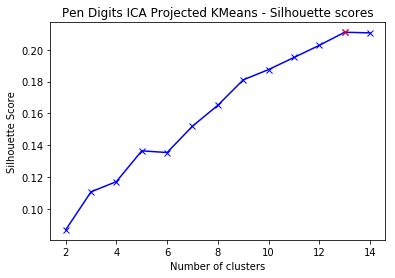

In [620]:
range_n_clusters = range(2,15)
silhouette_plot("KMeans", range_n_clusters, ica_projected_pen, "Pen Digits ICA Projected KMeans", 5)

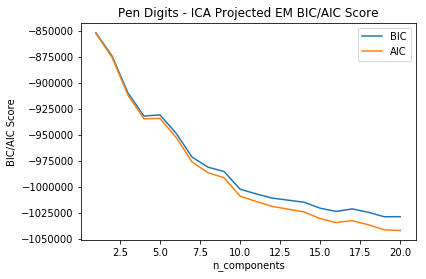

In [617]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full').fit(ica_projected_pen)
          for n in n_components]

plt.plot(n_components, [m.bic(ica_projected_pen) for m in models], label='BIC')
plt.plot(n_components, [m.aic(ica_projected_pen) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('BIC/AIC Score')
plt.title('Pen Digits - ICA Projected EM BIC/AIC Score')
plt.show()

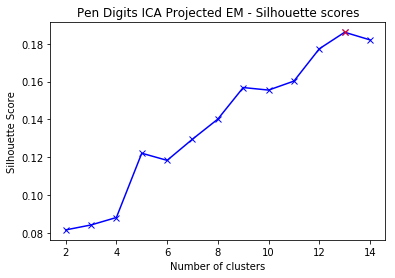

In [619]:
range_n_clusters = range(2,15)
silhouette_plot("GMM", range_n_clusters, ica_projected_pen, "Pen Digits ICA Projected EM", 5)

In [426]:
training_x2D_pen_ICA = TSNE(verbose=False, random_state=10).fit_transform(ica_projected_pen)

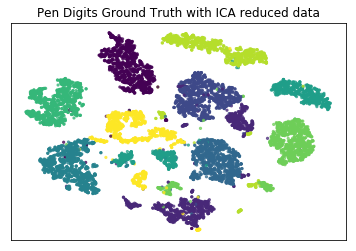

In [623]:
ds_2d = pd.DataFrame(np.hstack((training_x2D_pen_ICA, np.atleast_2d(y_pen).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Pen Digits Ground Truth with ICA reduced data")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

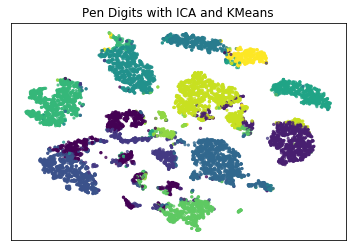

In [625]:
n_digits = 13
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(ica_projected_pen)

ds_2d = pd.DataFrame(np.hstack((training_x2D_pen_ICA, np.atleast_2d(kmeans.labels_).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Pen Digits with ICA and KMeans")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

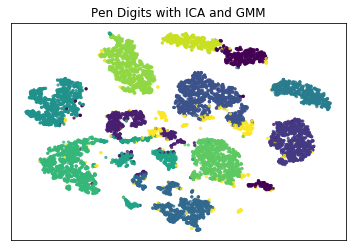

In [429]:
n_digits = 13
gmm = GaussianMixture(n_components=n_digits)
gmm = gmm.fit(ica_projected_pen)

ds_2d = pd.DataFrame(np.hstack((training_x2D_pen_ICA, np.atleast_2d(gmm.predict(ica_projected_pen)).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Pen Digits with ICA and GMM")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

### Adult Dataset

In [361]:
ica = FastICA(random_state=10, max_iter=20000)
ica.set_params(n_components=8)
ica_projected_adult = ica.fit_transform(X_adult)

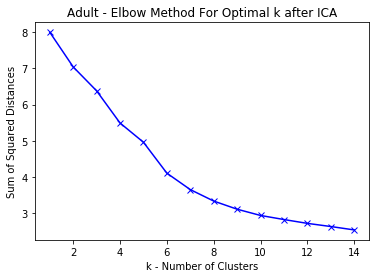

In [631]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(ica_projected_adult)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Adult - Elbow Method For Optimal k after ICA')
plt.show()

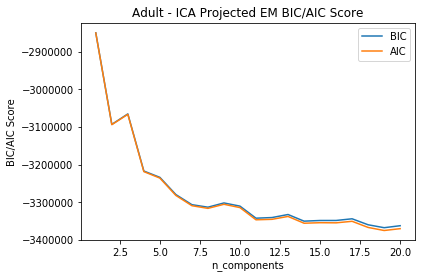

In [643]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full').fit(ica_projected_adult)
          for n in n_components]

plt.plot(n_components, [m.bic(ica_projected_adult) for m in models], label='BIC')
plt.plot(n_components, [m.aic(ica_projected_adult) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('BIC/AIC Score')
plt.title('Adult - ICA Projected EM BIC/AIC Score')
plt.show()

In [6]:
training_x2D_adult_ICA = TSNE(verbose=False, random_state=10).fit_transform(ica_projected_adult)

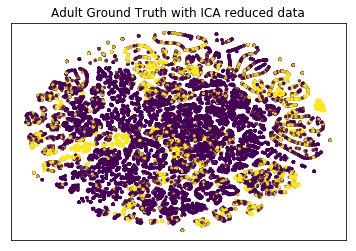

In [272]:
ds_2d = pd.DataFrame(np.hstack((training_x2D_adult_ICA, np.atleast_2d(y_adult).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Adult Ground Truth with ICA reduced data")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

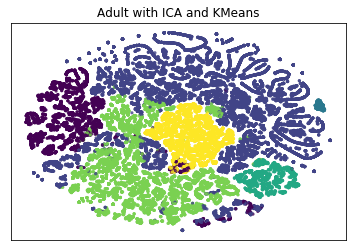

In [271]:
n_digits = 6
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(ica_projected_adult)

ds_2d = pd.DataFrame(np.hstack((training_x2D_adult_ICA, np.atleast_2d(kmeans.labels_).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Adult with ICA and KMeans")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

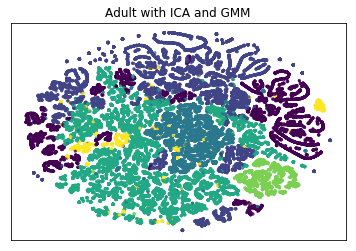

In [422]:
n_digits = 6
gmm = GaussianMixture(n_components=n_digits)
gmm = gmm.fit(ica_projected_adult)

ds_2d = pd.DataFrame(np.hstack((training_x2D_adult_ICA, np.atleast_2d(gmm.predict(ica_projected_adult)).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Adult with ICA and GMM")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

## Random Projections

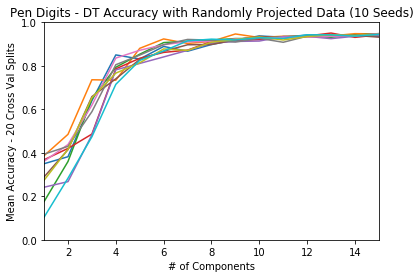

In [117]:
num_seeds = 10
ran_X_pen_dict = {}
for i in range(num_seeds):
    ran_X_pen_dict[i] = []
    
for state, dim in product(range(num_seeds), range(1, X_pen.shape[1]+1)):
    rp = SparseRandomProjection(random_state=state, n_components=dim)
    ran_X_pen_dict[state].append(rp.fit_transform(X_pen))

accuracies = {}
for i in range(len(ran_X_pen_dict)):
    accuracies[i] = []
    
n_feats = np.arange(1,X_pen.shape[1]+1)
for i in range(len(ran_X_pen_dict)):
    for X in ran_X_pen_dict[i]:
        acc = np.mean(cross_val_score(DecisionTreeClassifier(), X, y_pen, cv=20))
        accuracies[i].append(acc)

for i in range(len(accuracies)):
    plt.plot(range(1,X_pen.shape[1]+1), accuracies[i], label='Run ' + str(i))

plt.title('Pen Digits - DT Accuracy with Randomly Projected Data (10 Seeds)')
plt.ylabel('Mean Accuracy - 20 Cross Val Splits')
plt.xlabel('# of Components')
plt.ylim(0,1)
plt.xlim(1,X_pen.shape[1])
plt.show()

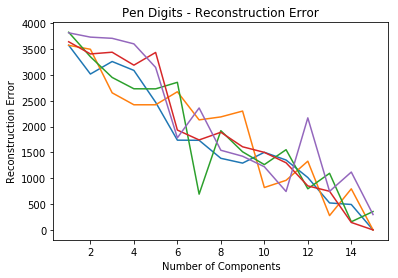

In [115]:
num_seeds = 5
recon_error = {}
for i in range(num_seeds):
    recon_error[i] = []
    
for state, dim in product(range(num_seeds), range(1, X_pen.shape[1]+1)):
    rp = SparseRandomProjection(n_components=dim, random_state=state)
    rp.fit(X_pen)
    recon_error[state].append(reconstructionError(rp, X_pen))

for i in range(len(recon_error)):
    plt.plot(range(1,X_pen.shape[1]+1), recon_error[i])

plt.title("Pen Digits - Reconstruction Error")
plt.ylabel("Reconstruction Error")
plt.xlabel("Number of Components")
plt.show()

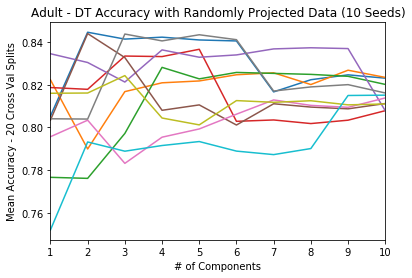

In [48]:
num_seeds = 10
ran_X_adult_dict = {}
for i in range(num_seeds):
    ran_X_adult_dict[i] = []
    
for state, dim in product(range(num_seeds), range(1, X_adult.shape[1]+1)):
    rp = SparseRandomProjection(random_state=state, n_components=dim)
    ran_X_adult_dict[state].append(rp.fit_transform(X_adult))

accuracies = {}
for i in range(len(ran_X_adult_dict)):
    accuracies[i] = []
    
n_feats = np.arange(1,X_adult.shape[1]+1)
for i in range(len(ran_X_adult_dict)):
    for X in ran_X_adult_dict[i]:
        acc = np.mean(cross_val_score(DecisionTreeClassifier(), X, y_adult, cv=20))
        accuracies[i].append(acc)

for i in range(len(accuracies)):
    plt.plot(range(1,X_adult.shape[1]+1), accuracies[i], label='Run ' + str(i))

plt.title('Adult - DT Accuracy with Randomly Projected Data (10 Seeds)')
plt.ylabel('Mean Accuracy - 20 Cross Val Splits')
plt.xlabel('# of Components')
plt.xlim(1,X_adult.shape[1])
plt.show()

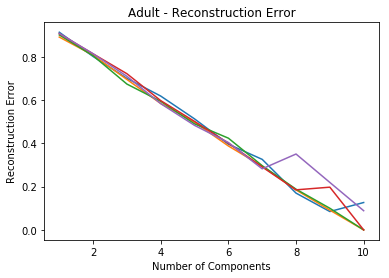

In [116]:
num_seeds = 5
recon_error = {}
for i in range(num_seeds):
    recon_error[i] = []
    
for state, dim in product(range(num_seeds), range(1, X_adult.shape[1]+1)):
    rp = SparseRandomProjection(n_components=dim, random_state=state)
    rp.fit(X_adult)
    recon_error[state].append(reconstructionError(rp, X_adult))

for i in range(len(recon_error)):
    plt.plot(range(1,X_adult.shape[1]+1), recon_error[i])

plt.title("Adult - Reconstruction Error")
plt.ylabel("Reconstruction Error")
plt.xlabel("Number of Components")
plt.show()

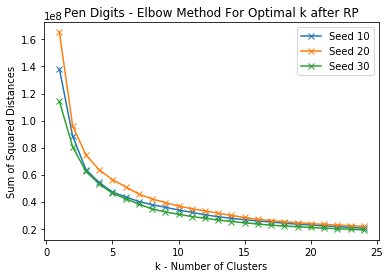

In [60]:
for i in range(1, 4):
    transformer = random_projection.SparseRandomProjection(n_components=10, random_state=i*10)
    rp_projected_pen = transformer.fit_transform(X_pen)

    Sum_of_squared_distances = []
    K = range(1,25)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(rp_projected_pen)
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, marker='x', label='Seed '+str(i*10))
plt.legend(loc='best')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Pen Digits - Elbow Method For Optimal k after RP')
plt.show()

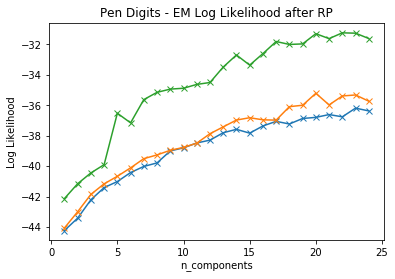

In [59]:
for i in range(1, 4):
    transformer = random_projection.SparseRandomProjection(n_components=10, random_state=i*10)
    rp_projected_pen = transformer.fit_transform(X_pen)

    log_prob = np.zeros(24)
    n = np.arange(1,25)
    models = []
    #loop through each number of Gaussians and compute the Log Prob, and save the model
    for i,j in enumerate(n):
        #create mixture model with j components
        gmm = GaussianMixture(n_components=j)
        #fit it to the data
        gmm.fit(rp_projected_pen)
        #compute the Log Prob for this model
        log_prob[i] = gmm.score(rp_projected_pen)
        #add the best-fit model with j components to the list of models
        models.append(gmm)

    plt.plot(n,log_prob, marker='x', label='Seed '+str(i))
    
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')
plt.title('Pen Digits - EM Log Likelihood after RP')
plt.show()

In [ ]:
num_seeds = 20
ran_X_adult_dict = {}
for i in range(num_seeds):
    ran_X_adult_dict[i] = []
    
for state, dim in product(range(num_seeds), range(1, X_adult.shape[1]+1)):
    rp = SparseRandomProjection(random_state=state, n_components=dim)
    ran_X_adult_dict[state].append(rp.fit_transform(X_adult))

In [ ]:
accuracies_adult = {}
for i in range(len(ran_X_adult_dict)):
    accuracies_adult[i] = []
    
n_feats = np.arange(1,X_adult.shape[1]+1)
for i in range(len(ran_X_adult_dict)):
    for X in ran_X_adult_dict[i]:
        acc = np.mean(cross_val_score(DecisionTreeClassifier(), X, y_adult, cv=3))
        accuracies_adult[i].append(acc)

In [ ]:
for i in range(len(accuracies_adult)):
    plt.plot(range(1,X_adult.shape[1]+1), accuracies_adult[i], label='Run ' + str(i))

plt.title('Adult - DT Accuracy over RP # Components (20 Seeds)')
plt.ylabel('Mean Accuracy for 3 Cross Val Splits')
plt.xlabel('# of Components')
plt.xlim(1,X_adult.shape[1])
plt.show()

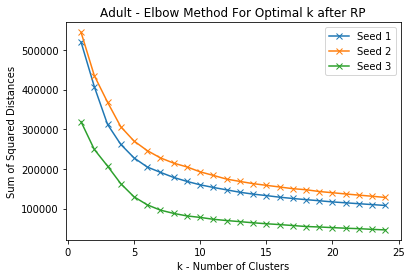

In [61]:
for i in range(1, 4):
    transformer = random_projection.SparseRandomProjection(n_components=8, random_state=i*20)
    rp_projected_adult = transformer.fit_transform(X_adult)

    Sum_of_squared_distances = []
    K = range(1,25)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(rp_projected_adult)
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, marker='x', label='Seed '+str(i))
plt.legend(loc='best')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Adult - Elbow Method For Optimal k after RP')
plt.show()

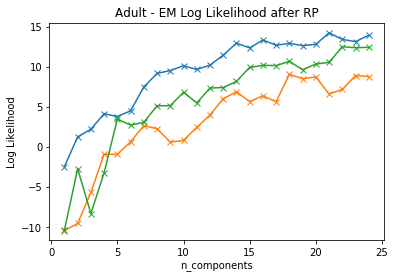

In [62]:
for i in range(1, 4):
    transformer = random_projection.SparseRandomProjection(n_components=8, random_state=i*10)
    rp_projected_adult = transformer.fit_transform(X_adult)

    log_prob = np.zeros(24)
    n = np.arange(1,25)
    models = []
    #loop through each number of Gaussians and compute the Log Prob, and save the model
    for i,j in enumerate(n):
        #create mixture model with j components
        gmm = GaussianMixture(n_components=j)
        #fit it to the data
        gmm.fit(rp_projected_adult)
        #compute the Log Prob for this model
        log_prob[i] = gmm.score(rp_projected_adult)
        #add the best-fit model with j components to the list of models
        models.append(gmm)

    plt.plot(n,log_prob, marker='x', label='Seed '+str(i))
    
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')
plt.title('Adult - EM Log Likelihood after RP')
plt.show()

In [766]:
transformer = random_projection.SparseRandomProjection(n_components=10, random_state=10)
rp_projected_pen = transformer.fit_transform(X_pen)

In [67]:
training_x2D_pen_RP = TSNE(verbose=False, random_state=10).fit_transform(rp_projected_pen)

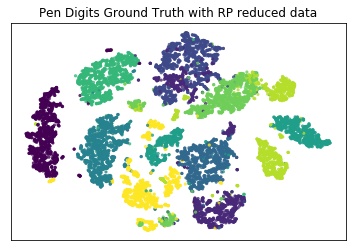

In [768]:
ds_2d = pd.DataFrame(np.hstack((training_x2D_pen_RP, np.atleast_2d(y_pen).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Pen Digits Ground Truth with RP reduced data")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

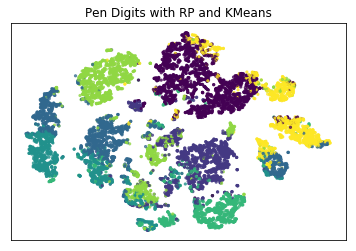

In [276]:
n_digits = 7
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(rp_projected_pen)

ds_2d = pd.DataFrame(np.hstack((training_x2D_pen_RP, np.atleast_2d(kmeans.labels_).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Pen Digits with RP and KMeans")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

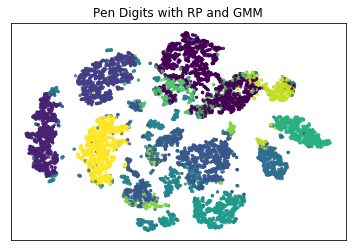

In [420]:
n_digits = 12
gmm = GaussianMixture(n_components=n_digits)
gmm = gmm.fit(rp_projected_pen)

ds_2d = pd.DataFrame(np.hstack((training_x2D_pen_RP, np.atleast_2d(gmm.predict(rp_projected_pen)).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Pen Digits with RP and GMM")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

In [418]:
transformer = random_projection.SparseRandomProjection(n_components=8, random_state=10)
rp_projected_adult = transformer.fit_transform(X_adult)

In [123]:
training_x2D_adult_RP = TSNE(verbose=False, random_state=10).fit_transform(rp_projected_adult)

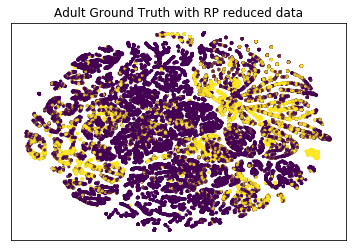

In [124]:
ds_2d = pd.DataFrame(np.hstack((training_x2D_adult_RP, np.atleast_2d(y_adult).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Adult Ground Truth with RP reduced data")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

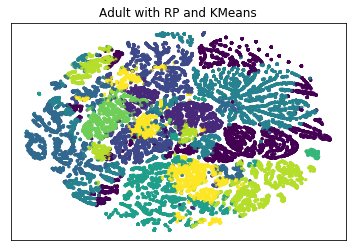

In [273]:
n_digits = 10
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(rp_projected_adult)

ds_2d = pd.DataFrame(np.hstack((training_x2D_adult_RP, np.atleast_2d(kmeans.labels_).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Adult with RP and KMeans")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

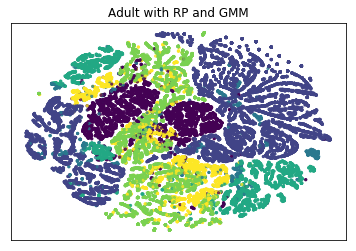

In [278]:
n_digits = 6
gmm = GaussianMixture(n_components=n_digits)
gmm = gmm.fit(rp_projected_adult)

ds_2d = pd.DataFrame(np.hstack((training_x2D_adult_RP, np.atleast_2d(gmm.predict(rp_projected_adult)).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Adult with RP and GMM")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

## Random Forest

In [53]:
rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=5,n_jobs=-1)
fs_pen = rfc.fit(X_pen,y_pen).feature_importances_ 
fs_adult = rfc.fit(X_adult,y_adult).feature_importances_

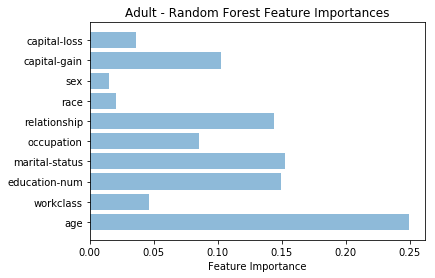

In [183]:
adult_headers = [
    'age',
    'workclass',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
]
pos = np.arange(len(fs_adult))
plt.barh(pos, fs_adult, align='center', alpha=0.5)
plt.yticks(pos, adult_headers)
plt.xlabel('Feature Importance')
plt.title('Adult - Random Forest Feature Importances')
plt.show()

In [54]:
adult_thres = np.mean(fs_adult) - np.std(fs_adult)
rf_X_adult = X_adult[:, fs_adult >= adult_thres]
print (X_adult.shape)
print (rf_X_adult.shape)

(45221, 10)
(45221, 8)


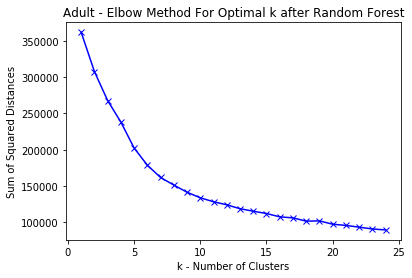

In [259]:
Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(rf_X_adult)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Adult - Elbow Method For Optimal k after Random Forest')
plt.show()

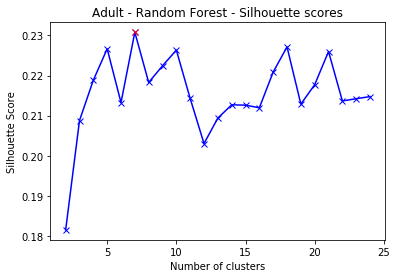

In [287]:
range_n_clusters = range(2,25)
silhouette_plot("KMeans", range_n_clusters, rf_X_adult, "Adult - Random Forest", 10)

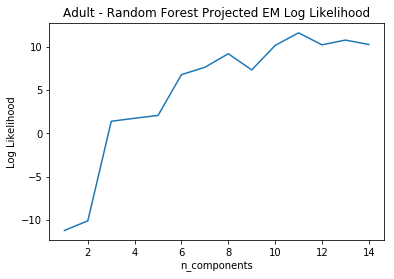

In [269]:
log_prob = np.zeros(14)

n = np.arange(1,15)
models = []
#loop through each number of Gaussians and compute the Log Prob, and save the model
for i,j in enumerate(n):
    #create mixture model with j components
    gmm = GaussianMixture(n_components=j, random_state=5)
    #fit it to the data
    gmm.fit(rf_X_adult)
    #compute the Log Prob for this model
    log_prob[i] = gmm.score(rf_X_adult)
    #add the best-fit model with j components to the list of models
    models.append(gmm)

plt.plot(n,log_prob)
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')
plt.title('Adult - Random Forest Projected EM Log Likelihood')
plt.show()

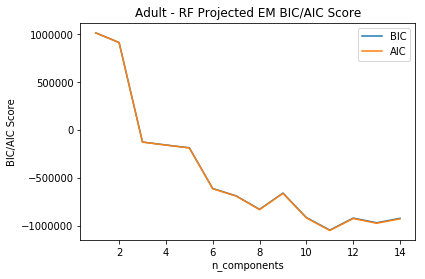

In [57]:
n_components = np.arange(1, 15)
models = [GaussianMixture(n, covariance_type='full', random_state=5).fit(rf_X_adult)
          for n in n_components]

plt.plot(n_components, [m.bic(rf_X_adult) for m in models], label='BIC')
plt.plot(n_components, [m.aic(rf_X_adult) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('BIC/AIC Score')
plt.title('Adult - RF Projected EM BIC/AIC Score')
plt.show()

In [262]:
training_x2D_adult_RF = TSNE(verbose=False, random_state=1).fit_transform(rf_X_adult)

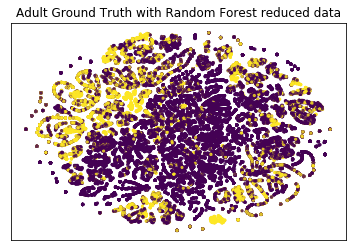

In [263]:
ds_2d = pd.DataFrame(np.hstack((training_x2D_adult_RF, np.atleast_2d(y_adult).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Adult Ground Truth with Random Forest reduced data")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

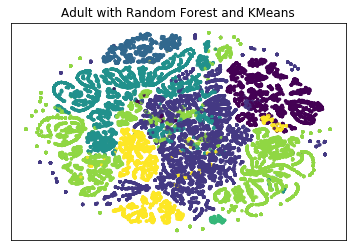

In [289]:
n_digits = 7
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(rf_X_adult)

ds_2d = pd.DataFrame(np.hstack((training_x2D_adult_RF, np.atleast_2d(kmeans.labels_).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Adult with Random Forest and KMeans")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

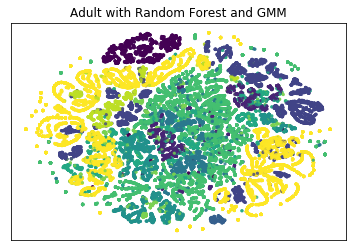

In [280]:
n_digits = 11
gmm = GaussianMixture(n_components=n_digits)
gmm = gmm.fit(rf_X_adult)

ds_2d = pd.DataFrame(np.hstack((training_x2D_adult_RF, np.atleast_2d(gmm.predict(rf_X_adult)).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Adult with Random Forest and GMM")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

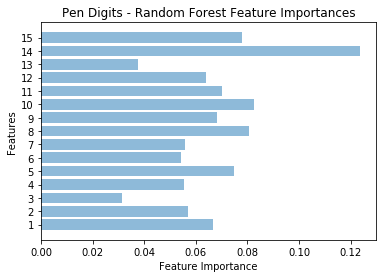

In [185]:
pos = np.arange(len(fs_pen))
plt.barh(pos, fs_pen, align='center', alpha=0.5)
plt.yticks(pos, np.arange(1,len(fs_pen)+1))
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Pen Digits - Random Forest Feature Importances')
plt.show()

In [64]:
pen_thres = np.mean(fs_pen) - 0.5 * np.std(fs_pen)
rf_X_pen = X_pen[:, fs_pen >= pen_thres]
print (X_pen.shape)
print (rf_X_pen.shape)

(10991, 15)
(10991, 10)


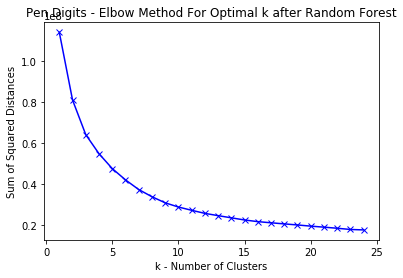

In [220]:
Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(rf_X_pen)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k - Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Pen Digits - Elbow Method For Optimal k after Random Forest')
plt.show()

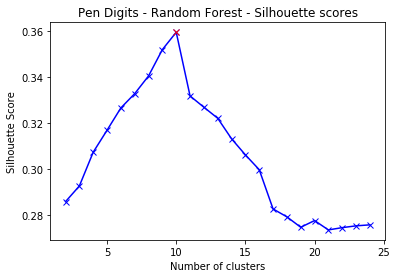

In [221]:
range_n_clusters = range(2,25)
silhouette_plot("KMeans", range_n_clusters, rf_X_pen, "Pen Digits - Random Forest", 10)

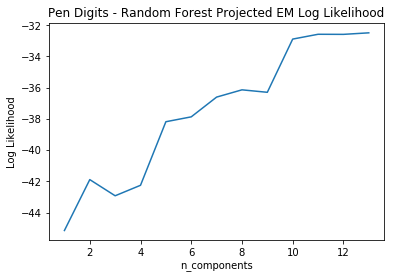

In [325]:
log_prob = np.zeros(13)

n = np.arange(1,14)
models = []
#loop through each number of Gaussians and compute the Log Prob, and save the model
for i,j in enumerate(n):
    #create mixture model with j components
    gmm = GaussianMixture(n_components=j, random_state=29)
    #fit it to the data
    gmm.fit(rf_X_pen)
    #compute the Log Prob for this model
    log_prob[i] = gmm.score(rf_X_pen)
    #add the best-fit model with j components to the list of models
    models.append(gmm)

plt.plot(n,log_prob)
plt.xlabel('n_components')
plt.ylabel('Log Likelihood')
plt.title('Pen Digits - Random Forest Projected EM Log Likelihood')
plt.show()

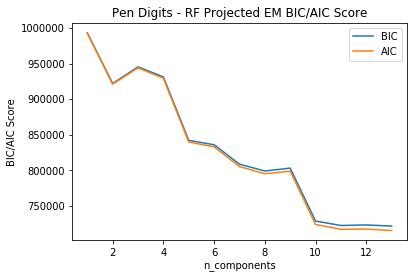

In [66]:
n_components = np.arange(1, 14)
models = [GaussianMixture(n, covariance_type='full', random_state=29).fit(rf_X_pen)
          for n in n_components]

plt.plot(n_components, [m.bic(rf_X_pen) for m in models], label='BIC')
plt.plot(n_components, [m.aic(rf_X_pen) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('BIC/AIC Score')
plt.title('Pen Digits - RF Projected EM BIC/AIC Score')
plt.show()

In [231]:
training_x2D_pen_RF = TSNE(verbose=False, random_state=10).fit_transform(rf_X_pen)

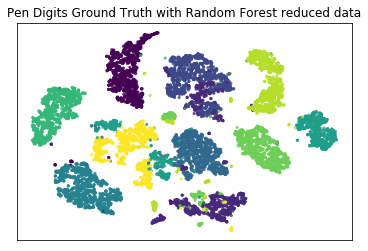

In [232]:
ds_2d = pd.DataFrame(np.hstack((training_x2D_pen_RF, np.atleast_2d(y_pen).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Pen Digits Ground Truth with Random Forest reduced data")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

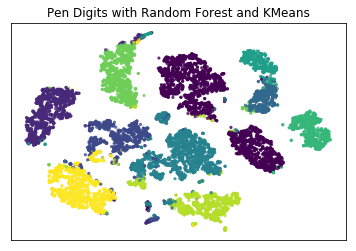

In [340]:
n_digits = 10
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(rf_X_pen)

ds_2d = pd.DataFrame(np.hstack((training_x2D_pen_RF, np.atleast_2d(kmeans.labels_).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Pen Digits with Random Forest and KMeans")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

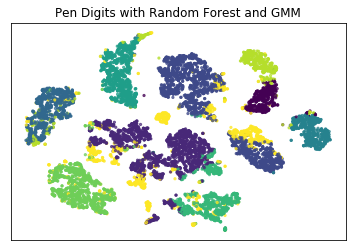

In [354]:
n_digits = 10
gmm = GaussianMixture(n_components=n_digits)
gmm = gmm.fit(rf_X_pen)

ds_2d = pd.DataFrame(np.hstack((training_x2D_pen_RF, np.atleast_2d(gmm.predict(rf_X_pen)).T)),
                             columns=['x', 'y', 'target'])
df = ds_2d
possible_clusters = list(set(df['target']))

plt.gca()
plt.title("Pen Digits with Random Forest and GMM")
plt.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
plt.xticks([])
plt.yticks([])
plt.grid(None)
plt.axis('tight')
plt.show()

# Experiment 4: Neural Networks after Dimensionality Reduction

## Baseline from Assignment 1

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_adult, y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 13 s, sys: 69 ms, total: 13.1 s
Wall time: 13.2 s
Confusion Matrix:
[[6371  502]
 [ 894 1278]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6873
           1       0.72      0.59      0.65      2172

   micro avg       0.85      0.85      0.85      9045
   macro avg       0.80      0.76      0.77      9045
weighted avg       0.84      0.85      0.84      9045

Accuracy   : 84.56605859590934
Train Score:  0.8397832817337462
CV Score   :  [0.84119745 0.83821212 0.83778404]
Test  Score:  0.8456605859590934


## PCA

In [68]:
X_train, X_test, y_train, y_test = train_test_split(pca_projected_adult, y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 10.2 s, sys: 68 ms, total: 10.3 s
Wall time: 10.4 s
Confusion Matrix:
[[6310  473]
 [1040 1222]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      6783
           1       0.72      0.54      0.62      2262

   micro avg       0.83      0.83      0.83      9045
   macro avg       0.79      0.74      0.76      9045
weighted avg       0.82      0.83      0.82      9045

Accuracy   : 83.27252625760089
Train Score:  0.8337295444493587
CV Score   :  [0.8345634  0.83804627 0.82691989]
Test  Score:  0.8327252625760089


## ICA

In [397]:
X_train, X_test, y_train, y_test = train_test_split(ica_projected_adult, y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 3.08 s, sys: 88.6 ms, total: 3.17 s
Wall time: 2.97 s
Confusion Matrix:
[[6843    0]
 [2202    0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      6843
           1       0.00      0.00      0.00      2202

   micro avg       0.76      0.76      0.76      9045
   macro avg       0.38      0.50      0.43      9045
weighted avg       0.57      0.76      0.65      9045

Accuracy   : 75.65505804311773
Train Score:  0.7510504201680672


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CV Score   :  [0.7510573  0.7510573  0.75103666]
Test  Score:  0.7565505804311774


## Random Projection

In [69]:
X_train, X_test, y_train, y_test = train_test_split(rp_projected_adult, y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 12.7 s, sys: 96.5 ms, total: 12.8 s
Wall time: 13 s
Confusion Matrix:
[[6315  463]
 [1035 1232]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      6778
           1       0.73      0.54      0.62      2267

   micro avg       0.83      0.83      0.83      9045
   macro avg       0.79      0.74      0.76      9045
weighted avg       0.83      0.83      0.83      9045

Accuracy   : 83.4383637368712
Train Score:  0.8341441839893853
CV Score   :  [0.83499171 0.83247636 0.83504727]
Test  Score:  0.834383637368712


## Random Forest

In [399]:
X_train, X_test, y_train, y_test = train_test_split(rf_X_adult, y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 9.54 s, sys: 100 ms, total: 9.64 s
Wall time: 9.4 s
Confusion Matrix:
[[6277  515]
 [ 954 1299]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      6792
           1       0.72      0.58      0.64      2253

   micro avg       0.84      0.84      0.84      9045
   macro avg       0.79      0.75      0.77      9045
weighted avg       0.83      0.84      0.83      9045

Accuracy   : 83.75898286346047
Train Score:  0.8414418398938522
CV Score   :  [0.8377975  0.84119745 0.84110134]
Test  Score:  0.8375898286346047


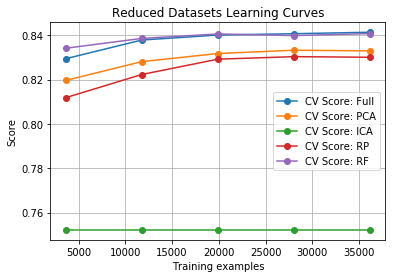

In [458]:
all_X = [X_adult, pca_projected_adult, ica_projected_adult, rp_projected_adult, rf_X_adult]
X_titles = ['Full', 'PCA', 'ICA', 'RP', 'RF']
clf = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
plot_learning_curves(clf, all_X, y_adult, 'Reduced Datasets Learning Curves', X_titles, cv=5, show=True)

# Experiment 5: Neural Nets using Clustering as Dimensionality Reduction

## PCA

In [377]:
km = KMeans(n_clusters=7)
km = km.fit(pca_projected_adult)
X_pca_km = km.fit_predict(X_adult).reshape(-1,1)

gmm = GaussianMixture(n_components=4)
gmm = gmm.fit(pca_projected_adult)
X_pca_gmm = gmm.fit_predict(X_adult).reshape(-1,1)

In [400]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_km, y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 5.88 s, sys: 89.8 ms, total: 5.97 s
Wall time: 5.69 s
Confusion Matrix:
[[6798    0]
 [2247    0]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      6798
           1       0.00      0.00      0.00      2247

   micro avg       0.75      0.75      0.75      9045
   macro avg       0.38      0.50      0.43      9045
weighted avg       0.56      0.75      0.64      9045

Accuracy   : 75.1575456053068
Train Score:  0.7522943387881469


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CV Score   :  [0.75230119 0.75230119 0.75228064]
Test  Score:  0.751575456053068


In [401]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_gmm, y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 3.52 s, sys: 84.1 ms, total: 3.6 s
Wall time: 3.33 s
Confusion Matrix:
[[6821    0]
 [2174   50]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      6821
           1       1.00      0.02      0.04      2224

   micro avg       0.76      0.76      0.76      9045
   macro avg       0.88      0.51      0.45      9045
weighted avg       0.82      0.76      0.66      9045

Accuracy   : 75.96462133775567
Train Score:  0.7566065900044229
CV Score   :  [0.75619869 0.75727672 0.75634434]
Test  Score:  0.7596462133775567


In [406]:
X_train, X_test, y_train, y_test = train_test_split(np.hstack((pca_projected_adult,X_pca_km)), y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 10.1 s, sys: 95 ms, total: 10.2 s
Wall time: 9.94 s
Confusion Matrix:
[[6362  469]
 [1021 1193]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      6831
           1       0.72      0.54      0.62      2214

   micro avg       0.84      0.84      0.84      9045
   macro avg       0.79      0.74      0.76      9045
weighted avg       0.83      0.84      0.83      9045

Accuracy   : 83.52681039248203
Train Score:  0.8355263157894737
CV Score   :  [0.83298781 0.83506095 0.83148117]
Test  Score:  0.8352681039248203


In [407]:
X_train, X_test, y_train, y_test = train_test_split(np.hstack((pca_projected_adult,X_pca_gmm)), y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 9.03 s, sys: 41.8 ms, total: 9.07 s
Wall time: 9.11 s
Confusion Matrix:
[[6327  510]
 [ 967 1241]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6837
           1       0.71      0.56      0.63      2208

   micro avg       0.84      0.84      0.84      9045
   macro avg       0.79      0.74      0.76      9045
weighted avg       0.83      0.84      0.83      9045

Accuracy   : 83.67053620784965
Train Score:  0.8300530738611234
CV Score   :  [0.82958786 0.83008541 0.82741748]
Test  Score:  0.8367053620784964


## ICA

In [430]:
km = KMeans(n_clusters=6)
km = km.fit(ica_projected_adult)
X_ica_km = km.fit_predict(X_adult).reshape(-1,1)

gmm = GaussianMixture(n_components=6)
gmm = gmm.fit(ica_projected_adult)
X_ica_gmm = gmm.fit_predict(X_adult).reshape(-1,1)

In [431]:
X_train, X_test, y_train, y_test = train_test_split(X_ica_km, y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 2.51 s, sys: 94.7 ms, total: 2.6 s
Wall time: 2.34 s
Confusion Matrix:
[[6810    0]
 [2235    0]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      6810
           1       0.00      0.00      0.00      2235

   micro avg       0.75      0.75      0.75      9045
   macro avg       0.38      0.50      0.43      9045
weighted avg       0.57      0.75      0.65      9045

Accuracy   : 75.29021558872306
Train Score:  0.7519626271561256


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CV Score   :  [0.75196948 0.75196948 0.75194891]
Test  Score:  0.7529021558872305


In [432]:
X_train, X_test, y_train, y_test = train_test_split(X_ica_km, y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 2.26 s, sys: 87.4 ms, total: 2.34 s
Wall time: 2.1 s
Confusion Matrix:
[[6782    0]
 [2263    0]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      6782
           1       0.00      0.00      0.00      2263

   micro avg       0.75      0.75      0.75      9045
   macro avg       0.37      0.50      0.43      9045
weighted avg       0.56      0.75      0.64      9045

Accuracy   : 74.98065229408513
Train Score:  0.7527366209641752


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CV Score   :  [0.75271581 0.75271581 0.75277824]
Test  Score:  0.7498065229408513


In [433]:
X_train, X_test, y_train, y_test = train_test_split(np.hstack((ica_projected_adult,X_ica_km)), y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 2.13 s, sys: 76.6 ms, total: 2.21 s
Wall time: 1.99 s
Confusion Matrix:
[[6839    0]
 [2206    0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      6839
           1       0.00      0.00      0.00      2206

   micro avg       0.76      0.76      0.76      9045
   macro avg       0.38      0.50      0.43      9045
weighted avg       0.57      0.76      0.65      9045

Accuracy   : 75.61083471531232
Train Score:  0.7511609907120743


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CV Score   :  [0.75114023 0.75114023 0.75120252]
Test  Score:  0.7561083471531233


In [435]:
X_train, X_test, y_train, y_test = train_test_split(np.hstack((ica_projected_adult,X_ica_gmm)), y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 3.26 s, sys: 19.7 ms, total: 3.28 s
Wall time: 3.31 s
Confusion Matrix:
[[6784    0]
 [2261    0]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      6784
           1       0.00      0.00      0.00      2261

   micro avg       0.75      0.75      0.75      9045
   macro avg       0.38      0.50      0.43      9045
weighted avg       0.56      0.75      0.64      9045

Accuracy   : 75.00276395798784
Train Score:  0.7526813356921717


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CV Score   :  [0.7526534  0.75269531 0.75269531]
Test  Score:  0.7500276395798784


## Random Projections

In [436]:
km = KMeans(n_clusters=10)
km = km.fit(rp_projected_adult)
X_rp_km = km.fit_predict(X_adult).reshape(-1,1)

gmm = GaussianMixture(n_components=6)
gmm = gmm.fit(rp_projected_adult)
X_rp_gmm = gmm.fit_predict(X_adult).reshape(-1,1)

In [437]:
X_train, X_test, y_train, y_test = train_test_split(X_rp_km, y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 2.46 s, sys: 13.3 ms, total: 2.47 s
Wall time: 2.48 s
Confusion Matrix:
[[6837    0]
 [2208    0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      6837
           1       0.00      0.00      0.00      2208

   micro avg       0.76      0.76      0.76      9045
   macro avg       0.38      0.50      0.43      9045
weighted avg       0.57      0.76      0.65      9045

Accuracy   : 75.58872305140963
Train Score:  0.7512162759840778


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CV Score   :  [0.75122315 0.75122315 0.75120252]
Test  Score:  0.7558872305140962


In [440]:
X_train, X_test, y_train, y_test = train_test_split(X_rp_km, y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 2.91 s, sys: 89.9 ms, total: 3 s
Wall time: 2.75 s
Confusion Matrix:
[[6775    0]
 [2270    0]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      6775
           1       0.00      0.00      0.00      2270

   micro avg       0.75      0.75      0.75      9045
   macro avg       0.37      0.50      0.43      9045
weighted avg       0.56      0.75      0.64      9045

Accuracy   : 74.90326147042565
Train Score:  0.7529301194161875


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CV Score   :  [0.75290216 0.7529441  0.7529441 ]
Test  Score:  0.7490326147042565


In [441]:
X_train, X_test, y_train, y_test = train_test_split(np.hstack((rp_projected_adult,X_rp_km)), y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 16 s, sys: 138 ms, total: 16.2 s
Wall time: 16 s
Confusion Matrix:
[[6218  590]
 [ 913 1324]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      6808
           1       0.69      0.59      0.64      2237

   micro avg       0.83      0.83      0.83      9045
   macro avg       0.78      0.75      0.77      9045
weighted avg       0.83      0.83      0.83      9045

Accuracy   : 83.38308457711443
Train Score:  0.832983193277311
CV Score   :  [0.82902156 0.83065185 0.83413501]
Test  Score:  0.8338308457711443


In [442]:
X_train, X_test, y_train, y_test = train_test_split(np.hstack((rp_projected_adult,X_rp_gmm)), y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 14.3 s, sys: 108 ms, total: 14.4 s
Wall time: 14.2 s
Confusion Matrix:
[[6385  508]
 [1002 1150]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      6893
           1       0.69      0.53      0.60      2152

   micro avg       0.83      0.83      0.83      9045
   macro avg       0.78      0.73      0.75      9045
weighted avg       0.82      0.83      0.83      9045

Accuracy   : 83.30569375345495
Train Score:  0.8307441397611677
CV Score   :  [0.8277635  0.8313293  0.82932493]
Test  Score:  0.8330569375345495


## Random Forests

In [444]:
km = KMeans(n_clusters=10)
km = km.fit(rf_X_adult)
X_rf_km = km.fit_predict(X_adult).reshape(-1,1)

gmm = GaussianMixture(n_components=6)
gmm = gmm.fit(rf_X_adult)
X_rf_gmm = gmm.fit_predict(X_adult).reshape(-1,1)

In [445]:
X_train, X_test, y_train, y_test = train_test_split(X_rf_km, y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 10.7 s, sys: 44.3 ms, total: 10.7 s
Wall time: 10.7 s
Confusion Matrix:
[[6804    0]
 [2241    0]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      6804
           1       0.00      0.00      0.00      2241

   micro avg       0.75      0.75      0.75      9045
   macro avg       0.38      0.50      0.43      9045
weighted avg       0.57      0.75      0.65      9045

Accuracy   : 75.22388059701493
Train Score:  0.7521284829721362


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CV Score   :  [0.75213533 0.75213533 0.75211478]
Test  Score:  0.7522388059701492


In [448]:
X_train, X_test, y_train, y_test = train_test_split(X_rf_km, y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 9.32 s, sys: 350 ms, total: 9.67 s
Wall time: 9.21 s
Confusion Matrix:
[[6867    0]
 [2178    0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      6867
           1       0.00      0.00      0.00      2178

   micro avg       0.76      0.76      0.76      9045
   macro avg       0.38      0.50      0.43      9045
weighted avg       0.58      0.76      0.66      9045

Accuracy   : 75.92039800995025
Train Score:  0.7503869969040248


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CV Score   :  [0.7503939 0.7503939 0.7503732]
Test  Score:  0.7592039800995025


In [446]:
X_train, X_test, y_train, y_test = train_test_split(np.hstack((rf_X_adult,X_rf_km)), y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 9.17 s, sys: 112 ms, total: 9.28 s
Wall time: 9.07 s
Confusion Matrix:
[[6381  449]
 [1010 1205]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      6830
           1       0.73      0.54      0.62      2215

   micro avg       0.84      0.84      0.84      9045
   macro avg       0.80      0.74      0.76      9045
weighted avg       0.83      0.84      0.83      9045

Accuracy   : 83.86954118297402
Train Score:  0.843266253869969
CV Score   :  [0.83937308 0.8420267  0.84358932]
Test  Score:  0.8386954118297402


In [447]:
X_train, X_test, y_train, y_test = train_test_split(np.hstack((rf_X_adult,X_rf_gmm)), y_adult, test_size=0.20) 
classifier = MLPClassifier(activation = 'logistic', solver='adam',
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling',
                    random_state=1, warm_start = True, max_iter=10000)
%time classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy   :", accuracy_score(y_test, y_pred) * 100)
print("Train Score: ", classifier.score(X_train, y_train))
print("CV Score   : ", cross_val_score(classifier, X_train, y_train, cv=3))
print("Test  Score: ", classifier.score(X_test, y_test))

CPU times: user 11.1 s, sys: 105 ms, total: 11.2 s
Wall time: 11.1 s
Confusion Matrix:
[[6331  469]
 [ 976 1269]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6800
           1       0.73      0.57      0.64      2245

   micro avg       0.84      0.84      0.84      9045
   macro avg       0.80      0.75      0.77      9045
weighted avg       0.83      0.84      0.83      9045

Accuracy   : 84.02432283029297
Train Score:  0.8434597523219814
CV Score   :  [0.84409984 0.84003649 0.84450158]
Test  Score:  0.8402432283029297
